<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

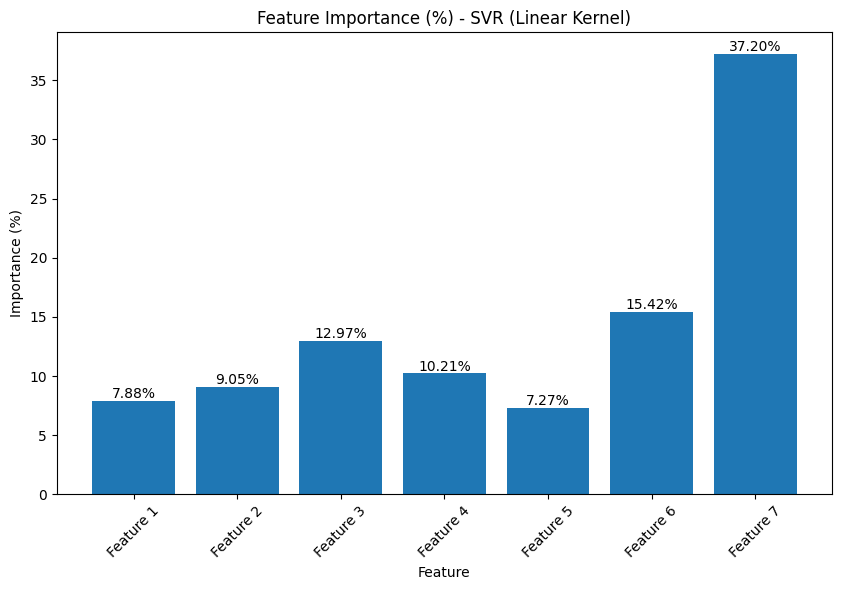

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load train and test datasets from uploaded .xlsx files
train_file = 'train.xlsx'  # Name of the training file
test_file = 'test.xlsx'    # Name of the test file

# Read Excel files
train_data = pd.read_excel(train_file)
test_data = pd.read_excel(test_file)

# Assuming the last column is the target variable and the rest are features for both train and test data
xtrain = train_data.iloc[:, :-1].values
ytrain = train_data.iloc[:, -1].values
xtest = test_data.iloc[:, :-1].values
ytest = test_data.iloc[:, -1].values  # True targets for the test set

# Normalize the data
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Define hyperparameter optimization options using Bayesian Optimization
from skopt import BayesSearchCV

# Create the SVR model
svr = SVR(kernel='linear')

# Set up the hyperparameter search space
search_space = {
    'C': (1e-3, 1e3, 'log-uniform'),  # BoxConstraint equivalent
    'epsilon': (1e-4, 1e-1, 'log-uniform')  # KernelScale can be interpreted as epsilon in SVR
}

# Optimize hyperparameters using Bayesian optimization
opt = BayesSearchCV(
    estimator=svr,
    search_spaces=search_space,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

# Fit the model
opt.fit(xtrain, ytrain)
svrModel = opt.best_estimator_

# Initial hyperparameters
initial_params = svr.get_params()

# Best tuned hyperparameters after optimization
tuned_params = opt.best_params_

# Predictions
SVR_Train_Pred = svrModel.predict(xtrain)
SVR_Test_Pred = svrModel.predict(xtest)

# Extract coefficients for feature importance
coefficients = np.abs(svrModel.coef_).flatten()

# Normalize coefficients to sum up to 100% for feature importance
importancePercentageSVR = (coefficients / np.sum(coefficients)) * 100

# Save predictions and feature importance to an Excel file
output_df = pd.DataFrame({
    'True Train Targets': ytrain,
    'Train Predictions': SVR_Train_Pred
})

output_test_df = pd.DataFrame({
    'True Test Targets': ytest,
    'Test Predictions': SVR_Test_Pred
})

importance_df = pd.DataFrame({
    'Feature': ['Feature ' + str(i + 1) for i in range(len(coefficients))],
    'Importance (%)': importancePercentageSVR
})

params_df = pd.DataFrame({
    'Initial Hyperparameters': [str(initial_params)],
    'Tuned Hyperparameters': [str(tuned_params)]
})

with pd.ExcelWriter('SVR_results.xlsx') as writer:
    output_df.to_excel(writer, sheet_name='Train Predictions', index=False)
    output_test_df.to_excel(writer, sheet_name='Test Predictions', index=False)
    importance_df.to_excel(writer, sheet_name='Feature Importance', index=False)
    params_df.to_excel(writer, sheet_name='Hyperparameters', index=False)

# Download the Excel file (use this in Colab)
from google.colab import files
files.download('SVR_results.xlsx')

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importancePercentageSVR)), importancePercentageSVR)
plt.title('Feature Importance (%) - SVR (Linear Kernel)')
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
plt.xticks(range(len(coefficients)), ['Feature ' + str(i + 1) for i in range(len(coefficients))], rotation=45)

# Add text labels above bars
for i, val in enumerate(importancePercentageSVR):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom')

plt.show()


In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00
